# Modelo: Regressão Linear

In [934]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

## Criando engine de conexão com o banco de dados

In [935]:
path_db = '../db/filmes.db'

In [936]:
engine = create_engine(f'sqlite:///{path_db}')

## Carregando o dataframe do banco de dados

In [937]:
df = pd.read_sql('SELECT * from filmes', con=engine)
df

,id,title,original_title,original_language,overview,budget,revenue,runtime,release_date,genres,popularity,vote_average,vote_count,num_genres,release_year
0,411405,Small Crimes,Small Crimes,en,"A disgraced former cop, fresh off a six-year p...",8.201666e+06,0.0,95.0,2017-04-28 00:00:00.000000,"['Drama', 'Comedy', 'Thriller', 'Crime']",7.219022,5.8,55.0,4,2017.0
1,42492,Up the Sandbox,Up the Sandbox,en,"A young wife and mother, bored with day-to-day...",3.543621e+05,0.0,97.0,1972-12-21 00:00:00.000000,"['Drama', 'Comedy']",0.138450,7.3,2.0,2,1972.0
2,12143,Bad Lieutenant,Bad Lieutenant,en,"While investigating a young nun's rape, a corr...",1.000000e+06,2019469.0,96.0,1992-09-16 00:00:00.000000,"['Crime', 'Drama']",6.417037,6.9,162.0,2,1992.0
3,9976,Satan's Little Helper,Satan's Little Helper,en,A naïve young boy unknowingly becomes the pawn...,1.890390e+06,0.0,100.0,2004-01-01 00:00:00.000000,"['Horror', 'Romance', 'Comedy']",2.233189,5.0,42.0,3,2004.0
4,46761,Sitcom,Sitcom,fr,The adventures of an upper-class suburban fami...,8.550376e+05,0.0,80.0,1998-05-27 00:00:00.000000,"['Comedy', 'Drama', 'Thriller']",1.800582,6.4,27.0,3,1998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3093,Basic Instinct 2,Basic Instinct 2,en,Novelist Catherine Tramell is once again in tr...,7.000000e+07,38629478.0,114.0,2006-03-29 00:00:00.000000,"['Crime', 'Mystery', 'Thriller']",15.321902,4.6,183.0,3,2006.0
4996,246127,Every Thing Will Be Fine,Every Thing Will Be Fine,en,"One day, driving aimlessly around the outskirt...",9.853274e+06,8034.0,118.0,2015-04-02 00:00:00.000000,['Drama'],5.723103,5.3,79.0,1,2015.0
4997,9803,Seven Dwarfs,7 Zwerge - Männer allein im Wald,de,The Seven Dwarves live deep within a female-fr...,9.674091e+06,0.0,95.0,2004-10-28 00:00:00.000000,['Comedy'],4.582736,5.2,70.0,1,2004.0
4998,336970,True Siblings,Syskonsalt,sv,"The siblings Linus, 19-years-old, who are taki...",1.060106e+06,0.0,58.0,2000-09-13 00:00:00.000000,"['Drama', 'TV Movie']",2.364355,8.0,2.0,2,2000.0


In [938]:
df.columns

Index(['id', 'title', 'original_title', 'original_language', 'overview',
       'budget', 'revenue', 'runtime', 'release_date', 'genres', 'popularity',
       'vote_average', 'vote_count', 'num_genres', 'release_year'],
      dtype='object')

Definimos as `features` do treinamento

In [939]:
features = ['budget', 'runtime', 'popularity', 'vote_average', 'vote_count', 'num_genres', 'release_year']

Selecionando as linhas para o dataframe válido onde `revenue > 0` e verificando que realmente nenhuma das `features` tem valor nulo em nenhuma linha.

In [940]:
df.loc[~df[features].isna().any(axis=1) & (df['revenue'] > 0), features].isna().sum()

budget          0
runtime         0
popularity      0
vote_average    0
vote_count      0
num_genres      0
release_year    0
dtype: int64

In [941]:
def avaliar_modelo_linear(df, coluna_alvo):
    
    df_valido = df.loc[~df[features].isna().any(axis=1) & (df[coluna_alvo] > 0)]
    
    X = df_valido.drop(columns=coluna_alvo)
    y = df_valido[coluna_alvo]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mses_error = []
    mses = []
    r2_scores = []
    
    for index_train, index_test in kf.split(X):
        X_train, X_test = X.iloc[index_train], X.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        
        mse = np.mean((y_pred - y_test)**2)
        mses.append(mse)
        
        mse_error = mean_squared_error(y_pred, y_test)
        mses_error.append(mse_error)
        
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        
    return {'media_mse_error': np.mean(mses_error),
            'media_mse': np.mean(mses),
            'media_r2': np.mean(r2_scores),
            'mse_error_std': np.std(mses_error),
            'mse_std': np.std(mses),
            'r2_std': np.std(r2_scores),
            'mses_error': mses_error,
            'mses': mses,
            'r2_scores': r2_scores}

In [942]:
avaliar_modelo_linear(df[features + ['revenue']], 'revenue')

{'media_mse_error': 9845324820269548.0,
 'media_mse': 9845324820269548.0,
 'media_r2': 0.3838071556263754,
 'mse_error_std': 9658069504033462.0,
 'mse_std': 9658069504033462.0,
 'r2_std': 0.5843286075712663,
 'mses_error': [6397186990016454.0,
  7802744781230349.0,
  3092153616162032.0,
  2.8807986118088268e+16,
  3126552595850637.0],
 'mses': [6397186990016454.0,
  7802744781230349.0,
  3092153616162032.0,
  2.8807986118088268e+16,
  3126552595850637.0],
 'r2_scores': [0.6366192536042996,
  0.6008492617578657,
  0.676382040501543,
  -0.7784097109777754,
  0.7835949332459442]}

Podemos notar que o `MSE manual` e com `sklearn.metrics.mean_squared_error` tem os mesmos valores para a coluna `revenue` e que ambos são altos com valor aproximado de `9.8 x 10^15`. Isso se dá por conta que tipicamente essa coluna tem uma grande variabilidade nos dados com receitas variando de milhôes a bilhões e da existencia outlies, então é natural que o `MSE` seja grande quando os valores são dessa magnitude. Em termos de variabilidade explicada, o `r2 médio` nos mostra que o modelo explica `38%` da variabilidade da receita dos filmes, ou seja, `38%` da variação total observada na variável dependente `y`, pode ser explicada pelas variáveis independentes `X` usadas no modelo. Para esse valor de `38%` indicam que explicam pouco da variação de `revenue`. Além disso, podemos perceber que há um alto desvio padrão na média dos erros (__MSE__) indicando que o desempenho do modelo varia muito de um `fold` para outro. Isso mostra que o modelo atual é instável. Então, vamos melhorar aplicando a transformação logarítmica.   

Antes, vamos remover os outliers em `revenue` para melhorar a performance do modelo nas predições através dos intervalos interquartis.

<Axes: xlabel='revenue'>

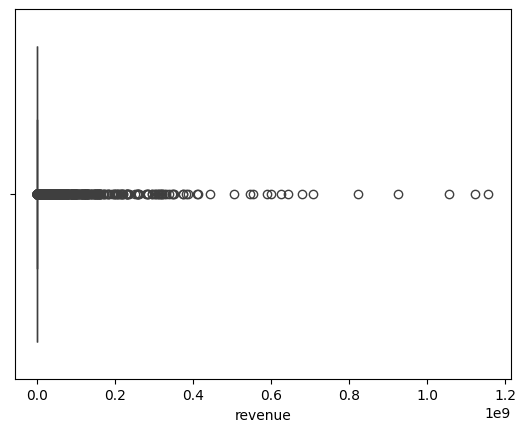

In [943]:
sns.boxplot(x=df['revenue'])

Podemos perceber que a direita do `boxplot` contém outliers que são os responsáveis por distorcer o modelo indicando que poucos filmes contém receitas muito altas enquanto que a maioria tem receitas de poucos milhões e tendendo a zero.

In [944]:
def outliers(df, coluna):
    
    Q1 = df[coluna].quantile(.25)
    Q3 = df[coluna].quantile(.75)
    
    IQR = Q3 - Q1
    
    limite_inferior = Q1 - 1.5*IQR
    limite_superior = Q3 + 1.5*IQR
    
    outliers_index = (df[coluna] < limite_inferior) | (df[coluna] > limite_superior)
    
    return df[outliers_index]

In [945]:
def avaliar_modelo_linear_log(df, coluna_alvo):
    
    df_valido = df.loc[~df[features].isna().any(axis=1) & (df[coluna_alvo] > 0)].copy()
    
    df_outliers = outliers(df_valido, coluna_alvo)
    df_valido = df_valido.drop(df_outliers.index)
    
    X = df_valido.drop(columns=coluna_alvo)
    y = np.log1p(df_valido[coluna_alvo])
        
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mses_error = []
    mses = []
    r2_scores = []
    
    for index_train, index_test in kf.split(X):
        X_train, X_test = X.iloc[index_train], X.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        
        mse = np.mean((y_pred - y_test)**2)
        mses.append(mse)
        
        mse_error = mean_squared_error(y_pred, y_test)
        mses_error.append(mse_error)
        
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        
    return {'media_mse_error': np.mean(mses_error),
            'media_mse': np.mean(mses),
            'media_r2': np.mean(r2_scores),
            'mse_error_std': np.std(mses_error),
            'mse_std': np.std(mses),
            'r2_std': np.std(r2_scores),
            'mses_error': mses_error,
            'mses': mses,
            'r2_scores': r2_scores}

Aplicando a transformação logarítmica temos os seguintes resultados das métricas.

In [946]:
avaliar_modelo_linear_log(df[features + ['revenue']], 'revenue')

{'media_mse_error': 7.3391859618041675,
 'media_mse': 7.3391859618041675,
 'media_r2': 0.23128663774929192,
 'mse_error_std': 2.0531801041590616,
 'mse_std': 2.0531801041590616,
 'r2_std': 0.08912078891890707,
 'mses_error': [4.404761802769118,
  10.510056949792926,
  6.362703485142391,
  8.478986328266453,
  6.939421243049951],
 'mses': [4.404761802769118,
  10.510056949792926,
  6.362703485142391,
  8.478986328266453,
  6.939421243049951],
 'r2_scores': [0.32400615001280775,
  0.07069767471031796,
  0.21300647168242615,
  0.24904535078774392,
  0.29967754155316384]}

Percebemos que a média manual e a do `sklearn` tem os mesmos valores em escala logarítmica. O erro de MAE é aproximadamente `7.33` e isso nos diz que, em média, o modelo faz previsões de `log(revenue)` com erro de `7.33` unidade logarítmicas e convertendo aproximadamente para a escala real dos valores em `revenue`, temos um erro de `e^(7.33)` que é aproximadamente `1525`, ou seja, o modelo costuma errar o valores previsto em `revenue` por um valor de `1525` vezes o que é um valor alto mas menor do que os quartilhões de diferença de antes. A média de `r^2` aproximadamente `0.23` em escala logarítmica nos diz que o modelo explica `23%` da variação da receita por meio das `features` isso é baixo mas mostra que o modelo está capturando algo útil e não apenas sendo aleatório ou constante. 

Agora vamos inputar a coluna `revenue`.

In [947]:
def inputar_coluna_log(df, coluna_alvo, colunas):
    
    valido = ~df[colunas].isna().any(axis=1)
    
    X_train = df.loc[valido & (df[coluna_alvo] > 0), colunas]
    Y_train = df.loc[valido & (df[coluna_alvo] > 0), coluna_alvo]
    X_pred = df.loc[valido & (df[coluna_alvo] == 0), colunas]
    
    Y_train_log = np.log1p(Y_train)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_pred_scaled = scaler.transform(X_pred)
    
    model = LinearRegression()
    model.fit(X_train_scaled, Y_train_log)
    
    Y_pred_log = model.predict(X_pred_scaled)
    
    Y_pred_original = np.expm1(Y_pred_log)
    
    df.loc[X_pred.index, coluna_alvo] = Y_pred_original
    
    return df

In [948]:
df_revenue_inputado = inputar_coluna_log(df, 'revenue', features)
df_revenue_inputado

C:\Users\Kleber\AppData\Local\Temp\ipykernel_38220\668643193.py:20: RuntimeWarning: overflow encountered in expm1
  Y_pred_original = np.expm1(Y_pred_log)


,id,title,original_title,original_language,overview,budget,revenue,runtime,release_date,genres,popularity,vote_average,vote_count,num_genres,release_year
0,411405,Small Crimes,Small Crimes,en,"A disgraced former cop, fresh off a six-year p...",8.201666e+06,4.243626e+06,95.0,2017-04-28 00:00:00.000000,"['Drama', 'Comedy', 'Thriller', 'Crime']",7.219022,5.8,55.0,4,2017.0
1,42492,Up the Sandbox,Up the Sandbox,en,"A young wife and mother, bored with day-to-day...",3.543621e+05,2.978317e+06,97.0,1972-12-21 00:00:00.000000,"['Drama', 'Comedy']",0.138450,7.3,2.0,2,1972.0
2,12143,Bad Lieutenant,Bad Lieutenant,en,"While investigating a young nun's rape, a corr...",1.000000e+06,2.019469e+06,96.0,1992-09-16 00:00:00.000000,"['Crime', 'Drama']",6.417037,6.9,162.0,2,1992.0
3,9976,Satan's Little Helper,Satan's Little Helper,en,A naïve young boy unknowingly becomes the pawn...,1.890390e+06,1.710526e+06,100.0,2004-01-01 00:00:00.000000,"['Horror', 'Romance', 'Comedy']",2.233189,5.0,42.0,3,2004.0
4,46761,Sitcom,Sitcom,fr,The adventures of an upper-class suburban fami...,8.550376e+05,2.725346e+06,80.0,1998-05-27 00:00:00.000000,"['Comedy', 'Drama', 'Thriller']",1.800582,6.4,27.0,3,1998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3093,Basic Instinct 2,Basic Instinct 2,en,Novelist Catherine Tramell is once again in tr...,7.000000e+07,3.862948e+07,114.0,2006-03-29 00:00:00.000000,"['Crime', 'Mystery', 'Thriller']",15.321902,4.6,183.0,3,2006.0
4996,246127,Every Thing Will Be Fine,Every Thing Will Be Fine,en,"One day, driving aimlessly around the outskirt...",9.853274e+06,8.034000e+03,118.0,2015-04-02 00:00:00.000000,['Drama'],5.723103,5.3,79.0,1,2015.0
4997,9803,Seven Dwarfs,7 Zwerge - Männer allein im Wald,de,The Seven Dwarves live deep within a female-fr...,9.674091e+06,1.694475e+06,95.0,2004-10-28 00:00:00.000000,['Comedy'],4.582736,5.2,70.0,1,2004.0
4998,336970,True Siblings,Syskonsalt,sv,"The siblings Linus, 19-years-old, who are taki...",1.060106e+06,4.436564e+06,58.0,2000-09-13 00:00:00.000000,"['Drama', 'TV Movie']",2.364355,8.0,2.0,2,2000.0


In [949]:
df = df_revenue_inputado.copy()

Abaixo, podemos perceber que os valores de índices `50` e `70` estão corrompidos e por conta deles o gráfico de disperssão fica explodido já que distorcem a escala. Então vamos retiralos do dataset.

In [950]:
df[['title', 'budget', 'revenue']].sort_values(by='revenue', ascending=False).head(10)

,title,budget,revenue
50,Scooby-Doo! and the Loch Ness Monster,1.000000e+11,inf
70,The Furies,3.140343e+06,1.170674e+33
3937,Pirates of the Caribbean: The Curse of the Bla...,1.400000e+08,3.625281e+10
4428,Life of Pi,1.200000e+08,6.589455e+09
4562,Minions,7.400000e+07,1.156731e+09
1301,Transformers: Dark of the Moon,1.950000e+08,1.123747e+09
4683,The Story of Film: An Odyssey,1.163809e+05,1.093441e+09
4233,Rogue One: A Star Wars Story,2.000000e+08,1.056057e+09
1349,Star Wars: Episode I - The Phantom Menace,1.150000e+08,9.243176e+08
1684,Spider-Man,1.390000e+08,8.217086e+08


In [951]:
index_outliers = [50, 70]

df = df.drop(index_outliers)

## Gráfico de dispersão com a reta ajustada

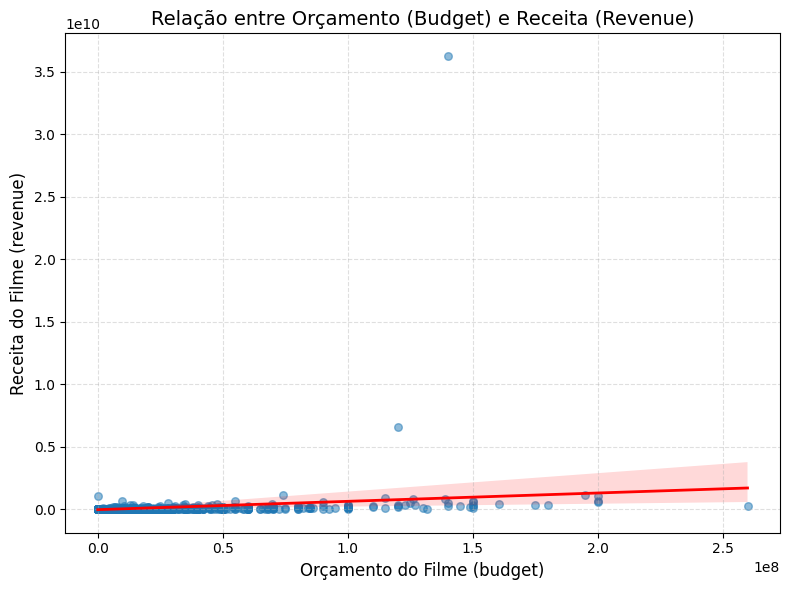

In [952]:
df_plot = df.loc[(df['budget'] > 0) & (df['revenue'] > 0)]

plt.figure(figsize=(8,6))

sns.regplot(
    x='budget',
    y='revenue',
    data=df_plot,
    scatter_kws={'alpha':0.5, 's':30},
    line_kws={'color':'red', 'lw':2},
)

plt.title('Relação entre Orçamento (Budget) e Receita (Revenue)', fontsize=14)
plt.xlabel('Orçamento do Filme (budget)', fontsize=12)
plt.ylabel('Receita do Filme (revenue)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [953]:
df.to_sql('filmes', con=engine, if_exists='replace', index=False)

4998